In [1]:
# Use seaborn for pairplot
!pip install --upgrade pip
!pip install seaborn
!pip install tensorflow

!pip install -q git+https://github.com/tensorflow/docs
# Use some functions from tensorflow_docs


Requirement already up-to-date: pip in c:\users\cmedders\anaconda3\lib\site-packages (20.0.2)


> Blockquote Initializing the dl

In [2]:

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Getting the file

In [3]:
data_file = 'C:/Users/cmedders/Data/Mostupdatedcalcyo.csv'
data_raw = pd.read_csv(data_file)
data = data_raw.copy()
data.tail()






,NACL,pH,pKa,TOT
16926,0.0,5.5,4.286085,1.0
16927,0.0,5.5,4.286085,1.0
16928,0.0,5.5,4.286085,1.0
16929,0.0,5.5,4.286085,1.0
16930,0.0,5.5,4.286085,1.0


# Splitting the file up so that testing has verifiable data

In [4]:
inputs_test = data.sample(frac=0.8,random_state=0)
outputs_test = data.drop(inputs_test.index)
outputs_test.tail()

,NACL,pH,pKa,TOT
16891,0.0,5.5,4.468997,0.6
16900,0.0,5.5,4.433701,0.7
16904,0.0,5.5,4.391670,0.8
16917,0.0,5.5,4.342539,0.9
16928,0.0,5.5,4.286085,1.0


# Checking out the stats of dataset

In [5]:
input_stats = inputs_test.describe()
input_stats.pop("pKa")
input_stats = input_stats.transpose()
input_stats


,count,mean,std,min,25%,50%,75%,max
NACL,13545.0,0.000775,0.024661,0.000,0.0,0.000,0.000,1.0
pH,13545.0,3.657276,0.392909,3.500,3.5,3.500,3.600,5.5
TOT,13545.0,0.431422,0.284438,0.001,0.2,0.391,0.661,1.0


# Manipulating Data

In [7]:
input_labels = inputs_test.pop("pKa")
output_labels = outputs_test.pop("pKa")

In [8]:
def norm(x):
    return(x - input_stats['mean'] / input_stats['std'])
normed_input_data = norm(inputs_test)
normed_test_data = norm(outputs_test)
normed_test_data.tail()


,NACL,pH,TOT
16891,-0.031434,-3.808207,-0.916751
16900,-0.031434,-3.808207,-0.816751
16904,-0.031434,-3.808207,-0.716751
16917,-0.031434,-3.808207,-0.616751
16928,-0.031434,-3.808207,-0.516751


# Building Model

In [9]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(inputs_test.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse'])
    return model

In [10]:
model = build_model()

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 12,801
Trainable params: 12,801
Non-trainable params: 0
_________________________________________________________________


In [12]:
example_batch = normed_input_data[0:10]
example_result = model.predict(example_batch)
example_batch.tail()

,NACL,pH,TOT
5606,-0.031434,-5.808207,-0.965751
6069,-0.031434,-5.808207,-0.915751
10106,-0.031434,-5.708207,-1.515751
1534,-0.031434,-5.808207,-1.375751
4436,-0.031434,-5.808207,-1.085751


# Testing Model

In [13]:
EPOCHS=1000
history = model.fit(
  normed_input_data, input_labels,
  epochs=EPOCHS, validation_split = 0.4, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.2307,  mae:0.2164,  mse:0.2307,  val_loss:0.0464,  val_mae:0.1619,  val_mse:0.0464,  
....................................................................................................
Epoch: 100, loss:0.0002,  mae:0.0100,  mse:0.0002,  val_loss:0.0002,  val_mae:0.0067,  val_mse:0.0002,  
....................................................................................................
Epoch: 200, loss:0.0002,  mae:0.0090,  mse:0.0002,  val_loss:0.0001,  val_mae:0.0080,  val_mse:0.0001,  
....................................................................................................
Epoch: 300, loss:0.0002,  mae:0.0081,  mse:0.0002,  val_loss:0.0003,  val_mae:0.0158,  val_mse:0.0003,  
....................................................................................................
Epoch: 400, loss:0.0001,  mae:0.0075,  mse:0.0001,  val_loss:0.0002,  val_mae:0.0122,  val_mse:0.0002,  
........................................................................

In [14]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.000086,0.005504,0.000086,0.000091,0.006428,0.000091,995
996,0.000081,0.005315,0.000081,0.000212,0.012282,0.000212,996
997,0.000081,0.005360,0.000081,0.000061,0.004458,0.000061,997
998,0.000080,0.005091,0.000080,0.000110,0.007290,0.000110,998
999,0.000086,0.005301,0.000086,0.000108,0.007127,0.000108,999


In [15]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [pKa]')

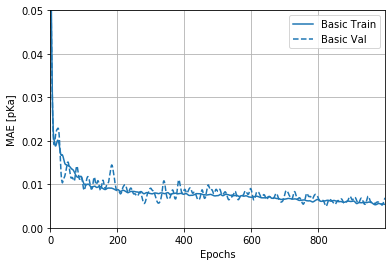

In [16]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, .05])
plt.ylabel('MAE [pKa]')

Text(0, 0.5, 'MSE [pKa^2]')

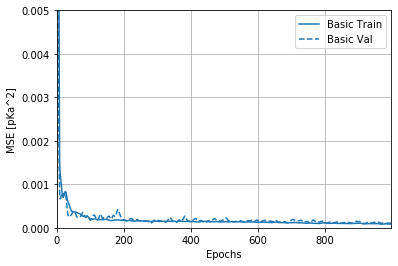

In [17]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 0.005])
plt.ylabel('MSE [pKa^2]')

In [18]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

early_history = model.fit(normed_input_data, input_labels, 
                    epochs=EPOCHS, validation_split = .5, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.3237,  mae:0.2504,  mse:0.3237,  val_loss:0.0636,  val_mae:0.2277,  val_mse:0.0636,  
.................

Text(0, 0.5, 'MAE[pKa]')

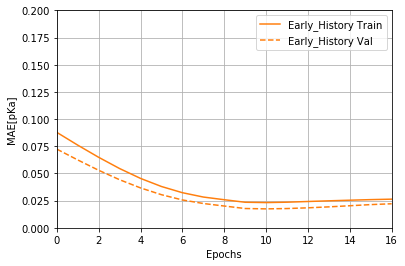

In [19]:
plotter.plot({'Early_History': early_history}, metric = "mae")
plt.ylim([0,.2])
plt.ylabel('MAE[pKa]')

In [20]:
loss, mae, mse = model.evaluate(normed_test_data, output_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} pKa".format(mae))

3386/3386 - 0s - loss: 3.5287e-04 - mae: 0.0110 - mse: 3.5287e-04
Testing set Mean Abs Error:  0.01 pKa


# Uneccessary corrections ... ?

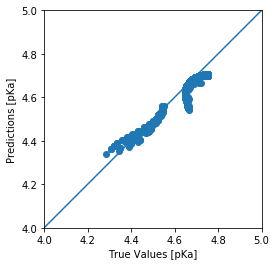

In [21]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(output_labels, test_predictions)
plt.xlabel('True Values [pKa]')
plt.ylabel('Predictions [pKa]')
lims = [4, 5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)




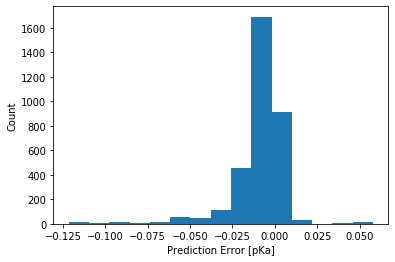

In [22]:
error = test_predictions - output_labels
plt.hist(error, bins = 15)
plt.xlabel("Prediction Error [pKa]")
_ = plt.ylabel("Count")

# Predict what you want its goes NACL, pH, Total buffer amount i know its weird

In [23]:
 x = [[0.3, 5.1, 0.02]]
df= pd.DataFrame(x, columns = ['NACL', 'pH', 'TOT'])
normdf = norm(df)
answer = model.predict(normdf)
dif= df.iloc[0,1]-answer[0]
molratio = np.power(10,dif)
mwA = 82.03
mHA = 17.4
mol_of_HA = df.iloc[0,2]/(molratio + 1)
mL_of_HA = mol_of_HA/17.4*1000
mol_A = df.iloc[0,2]-mol_of_HA
g_of_A = mol_A*mwA
print(g_of_A,"g of Sodium Acetate Anhydrous and ", mL_of_HA, "mLs of Glacial Acetic Acid", sep="")

[1.2871878]g of Sodium Acetate Anhydrous and [0.24760512]mLs of Glacial Acetic Acid


In [ ]:
!tensorboard dev upload --logdir  {logdir}/sizes